In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from mentorship.features.garment.etl import ETLTransformer
from mentorship.ml.cv.garment.split import splitter
from mentorship.ml.cv.util import format_cv_test_scores
from mentorship.ml.models.garment.boosting import LGBMPipelineClf
from mentorship.ml.models.garment.logreg import LogRegPipeline
from mentorship.ml.models.garment.hyperparams.tuning import tune_hyperparams
from mentorship.ml.models.common import RecursiveTSEstimator
from mentorship.ml.tools.garment.evaluation import plot_confusion_matrix, plot_roc_auc, plot_precision_recall_auc

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
CV_METRICS = [
    'accuracy',
    'precision',
    'recall',
    'f1'
]

In [4]:
def final_preds_metrics(y_true, y_pred, save_scores=False, print_scores=True):
    scores = {'accuracy': round(accuracy_score(y_true, y_pred), 3),
              'precision': round(precision_score(y_true, y_pred), 3),
              'recall': round(recall_score(y_true, y_pred), 3),
              'f1': round(f1_score(y_true, y_pred), 3)}
    if print_scores:
        print('accuracy:', scores['accuracy'])
        print('precision:', scores['precision'])
        print('recall:', scores['recall'])
        print('f1:', scores['f1'])
    
    if save_scores:
        return scores

In [5]:
def train_val_scores(cv_scores, model='Logistic Regression'):
    metric_values = {}
    for metric_name in cv_scores[0]:
        metric_values[metric_name] = [cv_scores[0][metric_name], cv_scores[1][metric_name], cv_scores[2][metric_name]]
    sns.heatmap(data=pd.DataFrame(data=metric_values, index=['Train score', 'Val score', 'Val std']).T, annot=True, annot_kws={'fontsize': 15})
    plt.yticks(fontsize=15, rotation=0)
    plt.xticks(fontsize=15)
    plt.title(model, fontsize=15)

In [6]:
os.chdir(os.environ['PROJECT_ROOT'])
DATA_ROOT = Path('data', 'productivity-prediction-garment-employees')

In [7]:
# preparing the dataset (ETL stage)

train_data = pd.read_csv(DATA_ROOT / 'garments_worker_productivity.csv')
X = train_data.copy()

X = ETLTransformer().transform(X)
y = X['bigger_than_targeted'].copy()

X.sample(5)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,bigger_than_targeted
200,2015-01-13,Quarter2,sweing,Tuesday,8,0.80,25.90,1211.0,10170.0,60,0.0,0,0,57.0,1
888,2015-02-24,Quarter4,sweing,Tuesday,3,0.75,29.40,1172.0,6960.0,45,0.0,0,2,60.0,1
404,2015-01-25,Quarter4,finishing,Sunday,7,0.65,3.94,1.0,2160.0,0,0.0,0,0,14.0,1
545,2015-02-02,Quarter1,sweing,Monday,4,0.80,22.52,23122.0,7020.0,50,0.0,0,0,56.5,1
181,2015-01-12,Quarter2,sweing,Monday,3,0.80,19.87,941.0,6420.0,0,0.0,0,0,55.0,1


In [8]:
# dividing the whole dataset on train and test parts

X_train, y_train = X[X['date'] < '2015-03-05'], y.loc[X[X['date'] < '2015-03-05'].index]
X_test, y_test = X[X['date'] >= '2015-03-05'], y.loc[X[X['date'] >= '2015-03-05'].index]

In [9]:
# inner folds for params tuning

inner_folds = []
inner_folds.append((X_train[X_train['date'] <= '2015-01-20']['date'].unique(), X_train[(X_train['date'] > '2015-01-20') & (X_train['date'] <= '2015-01-27')]['date'].unique()))
inner_folds.append((X_train[X_train['date'] <= '2015-01-27']['date'].unique(), X_train[(X_train['date'] > '2015-01-27') & (X_train['date'] <= '2015-02-03')]['date'].unique()))

In [10]:
n_folds = 4
test_size = 6

### <u>Comment:</u> a value of the 'over_time' feature is unknown at the prediction time. Its value is filled with the median of the last observations (which belong to the corresponding time series)

# Logistic Regression

accuracy: 0.721 ± 0.030
precision: 0.746 ± 0.055
recall: 0.873 ± 0.013
f1: 0.803 ± 0.032


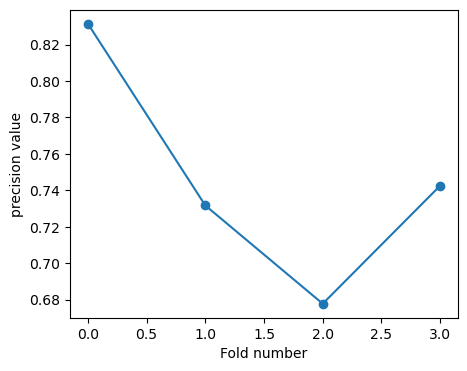

In [11]:
# cross validation

base_pipelines = {}
base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=['smv', 'wip', 'incentive', 'no_of_workers', 'over_time'],
                                          cols_to_encode=['day', 'team'], split_key='department',
                                          drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'],
                                          target_col='bigger_than_targeted', level='team')
base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=['smv', 'no_of_workers', 'over_time'],
                                             cols_to_encode=['day', 'team'], split_key='department', level='team',
                                             drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'],
                                             target_col='bigger_than_targeted')

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                                 target_col='bigger_than_targeted', learning_curve=True)

scores = cross_validate(modelling_pipeline_logreg, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', return_train_score=True, n_jobs=-1)
cv_scores = format_cv_test_scores(scores, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

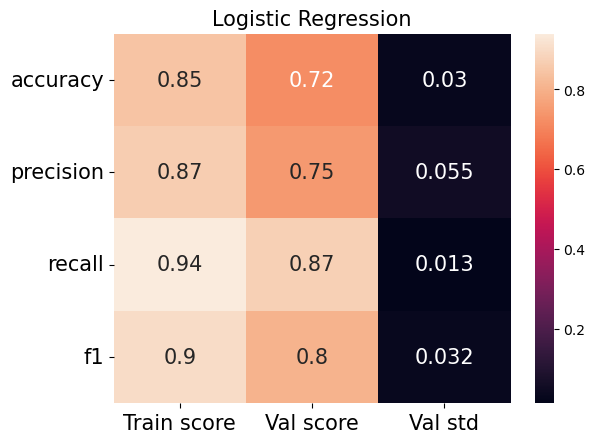

In [12]:
train_val_scores(cv_scores=cv_scores)

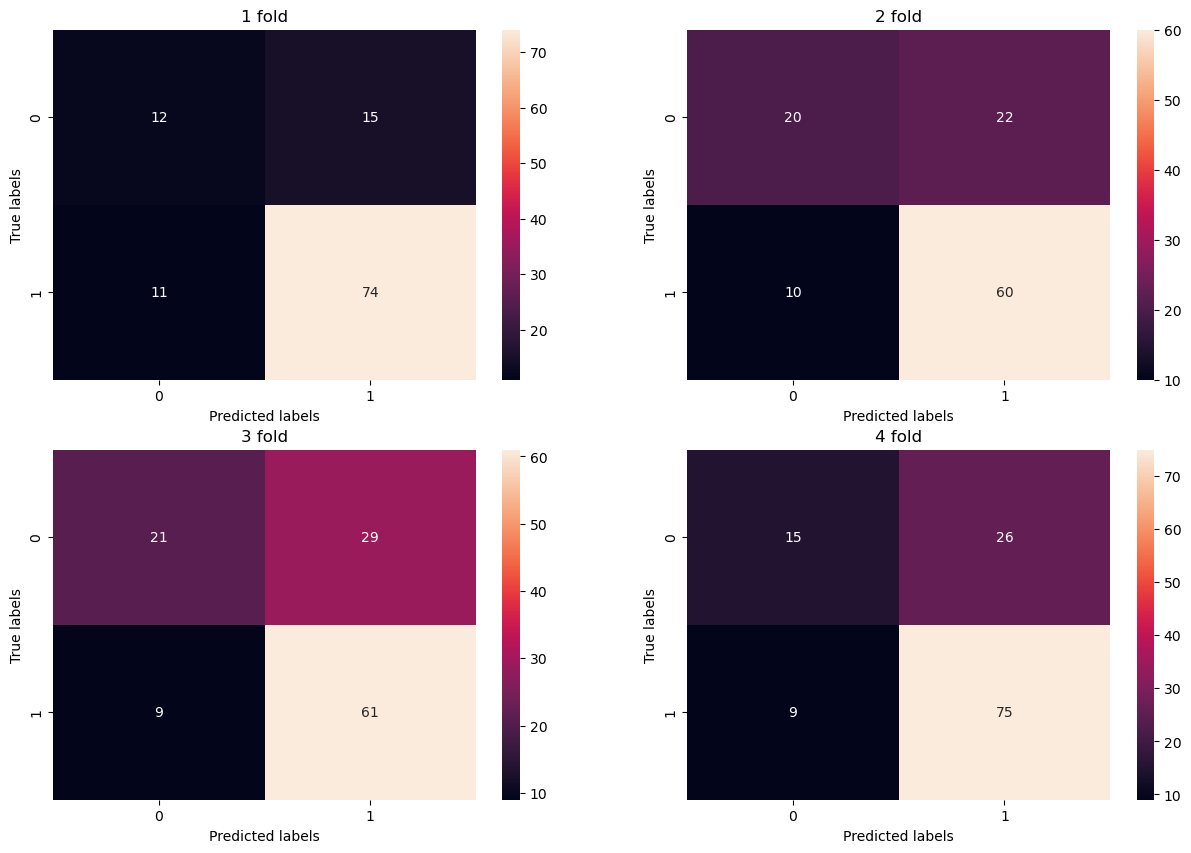

In [13]:
folds_indices = splitter(X_train)
plot_confusion_matrix(X=X_train, y=y_train, modelling_pipeline=modelling_pipeline_logreg, folds_indices=folds_indices)

<p><b><u>Note:</u> confusion matrix shows that most of mistakes (92 vs 39) are FP (predicted value is 1, but actual is 0). The main reason is probably the class imbalancing in data.</b></p>
<p><b><u>Solution:</u> it is necessary to try 'class_weights' parameter, that will force the loss function to pay more attention to the rare class (zero-class).</b></p>

### Analyze logistic regression for every 'department'

#### 'sweing'

accuracy: 0.822 ± 0.031
precision: 0.878 ± 0.013
recall: 0.883 ± 0.047
f1: 0.880 ± 0.027


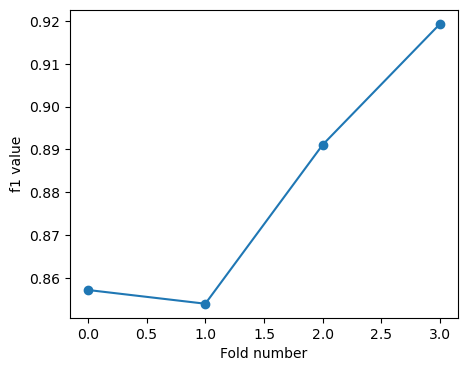

In [14]:
# cross-validation

X_train_sweing, y_train_sweing = X_train[X_train['department'] == 'sweing'].reset_index(drop=True), y_train.loc[X_train[X_train['department'] == 'sweing'].index].reset_index(drop=True)

scores = cross_validate(modelling_pipeline_logreg, X_train_sweing, y_train_sweing, cv=splitter(X_train_sweing), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

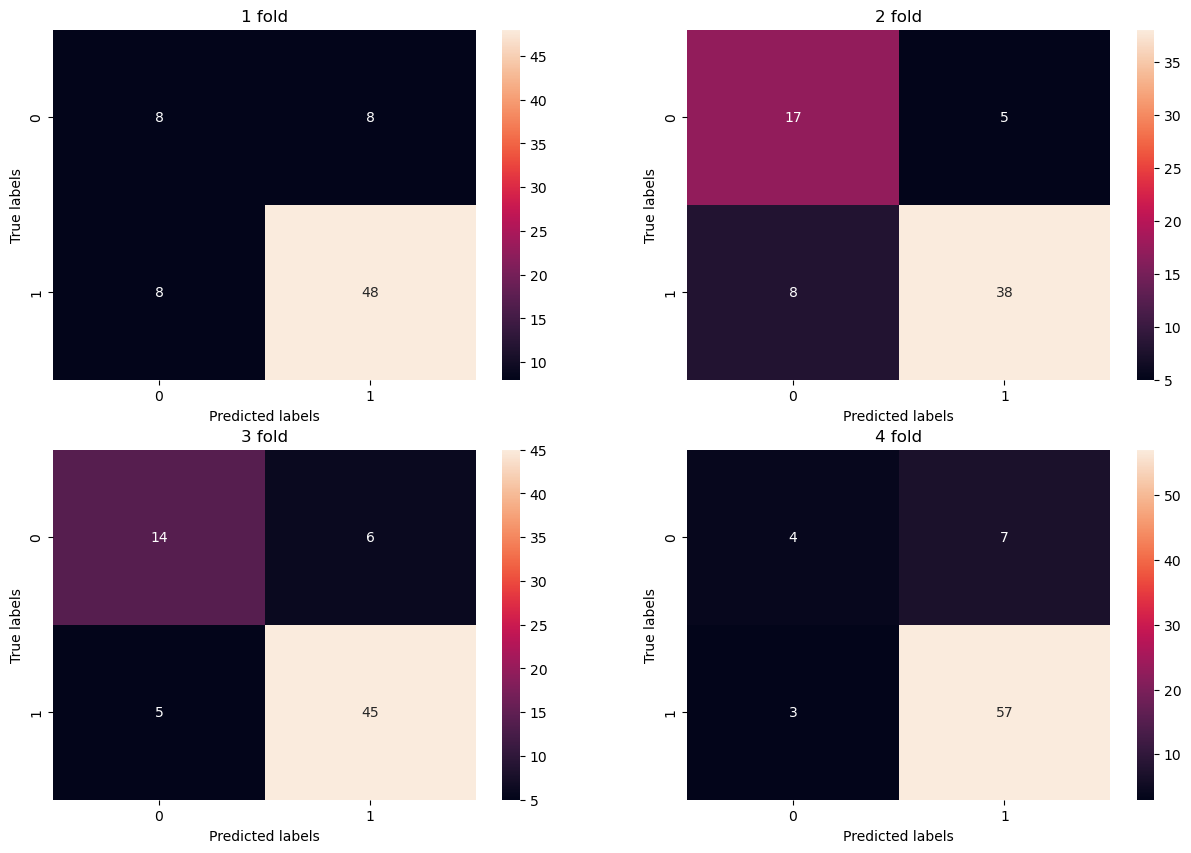

In [15]:
folds_indices_sweing = splitter(X_train_sweing)
plot_confusion_matrix(X_train_sweing, y_train_sweing, modelling_pipeline_logreg, folds_indices=folds_indices_sweing)

<p><b><u>Mistakes for 'sweing' department:</u> 26 FP, 24 FN (model nicely predicts both classes).</b></p>

#### 'finishing'

accuracy: 0.579 ± 0.106
precision: 0.562 ± 0.141
recall: 0.841 ± 0.069
f1: 0.667 ± 0.114


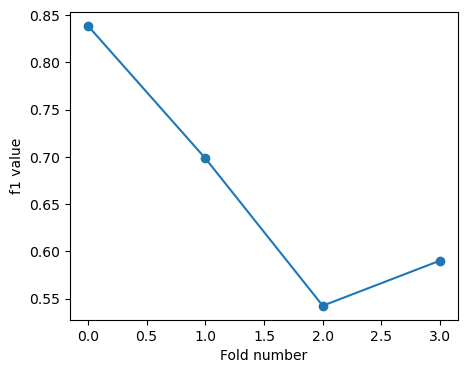

In [16]:
# cross-validation

X_train_finishing, y_train_finishing = X_train[X_train['department'] == 'finishing'].reset_index(drop=True), y_train.loc[X_train[X_train['department'] == 'finishing'].index].reset_index(drop=True)

scores = cross_validate(modelling_pipeline_logreg, X_train_finishing, y_train_finishing, cv=splitter(X_train_finishing), 
                        scoring=CV_METRICS, return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

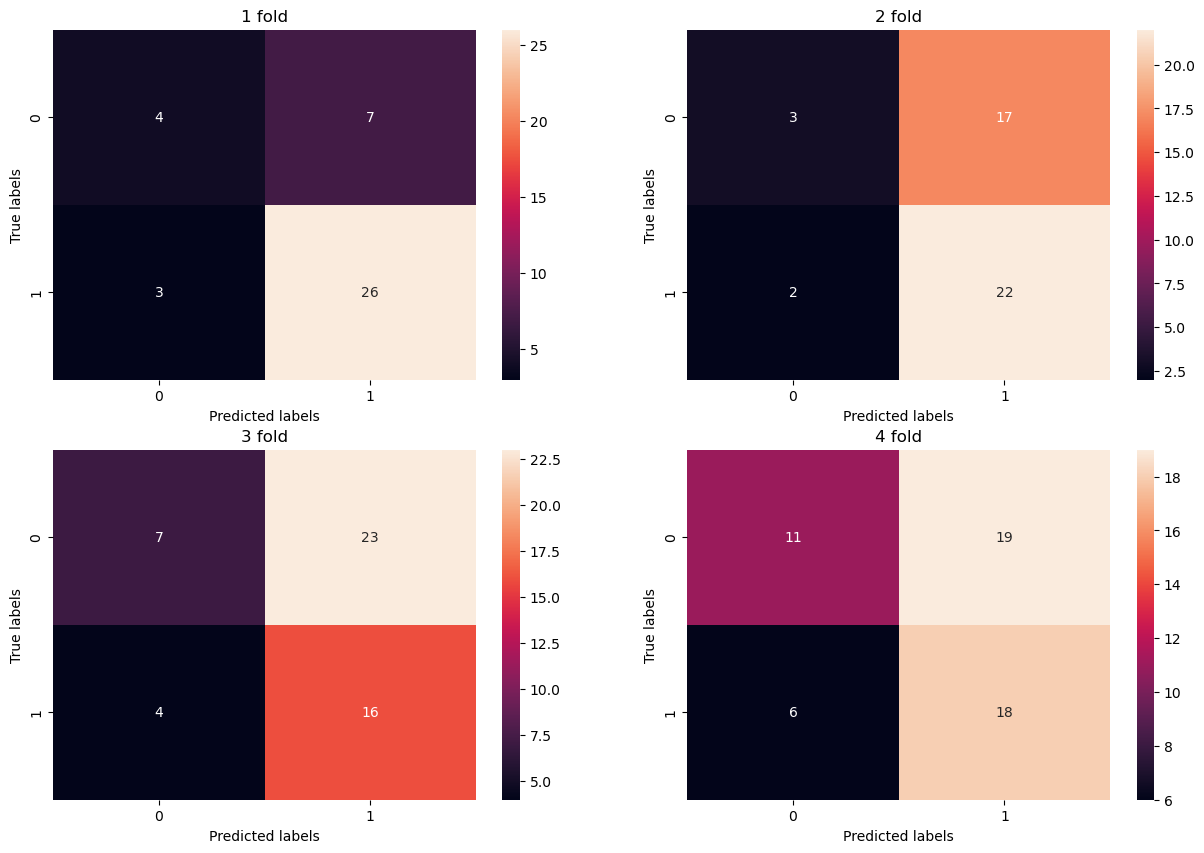

In [17]:
folds_indices_finishing = splitter(X_train_finishing)
plot_confusion_matrix(X_train_finishing, y_train_finishing, modelling_pipeline_logreg, folds_indices=folds_indices_finishing)

<p><b><u>Mistakes for 'finishing' department:</u> 63 FP, 15 FN (model has problems with zero-class).</b></p>

<p><b><u>Note:</u> Logistic Regression performs better with 'sweing' department. One of the reasons is that in 'sweing' department there are features which have good correlation with the target.</b></p>
<p><b><u>Solution:</u> it is necessary to try another model for this department (for example some tree-based model) which will able to catch non-linear dependencies.</b></p>

In [18]:
# getting X_train and y_train for the final model training

date_range_final = X_train['date'].unique()[test_size:]
X_train_final, y_train_final = X_train[X_train['date'].isin(date_range_final)], y_train.loc[X_train[X_train['date'].isin(date_range_final)].index]

accuracy: 0.76
precision: 0.866
recall: 0.824
f1: 0.844


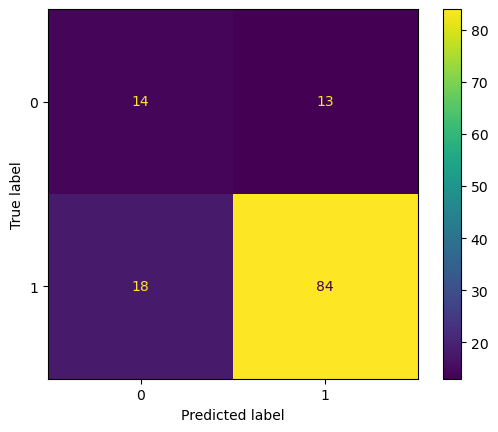

In [19]:
# fitting the final model and making predictions

modelling_pipeline_logreg.fit(X_train_final, y_train_final)
final_preds = modelling_pipeline_logreg.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, final_preds)

final_preds_metrics(y_test, final_preds)

# Logistic Regression with class_weights

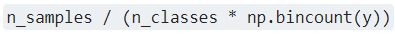

In [20]:
from sklearn.utils import class_weight

class_weights = {}
class_weights_sweing = class_weight.compute_class_weight(class_weight='balanced', y=X_train[X_train['department'] == 'sweing']['bigger_than_targeted'], classes=np.unique(y))
class_weights['sweing'] = {0: round(class_weights_sweing[0], 3), 1: round(class_weights_sweing[1], 3)}
class_weights_finishing = class_weight.compute_class_weight(class_weight='balanced', y=X_train[X_train['department'] == 'finishing']['bigger_than_targeted'], classes=np.unique(y))
class_weights['finishing'] = {0: round(class_weights_finishing[0], 3), 1: round(class_weights_finishing[1], 3)}
class_weights

{'sweing': {0: 2.752, 1: 0.611}, 'finishing': {0: 1.237, 1: 0.839}}

accuracy: 0.662 ± 0.041
precision: 0.750 ± 0.060
recall: 0.721 ± 0.056
f1: 0.734 ± 0.052


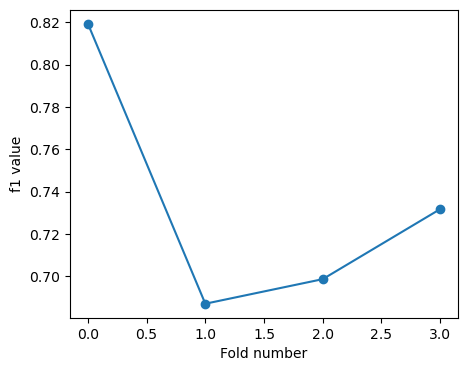

In [21]:
# cross validation

base_pipelines = {}
base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=['smv', 'wip', 'incentive', 'no_of_workers', 'over_time'],
                                          cols_to_encode=['day', 'team'], split_key='department',
                                          drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'],
                                          target_col='bigger_than_targeted', level='team')
base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=['smv', 'no_of_workers', 'over_time'],
                                             cols_to_encode=['day', 'team'],
                                             drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'],
                                             split_key='department', target_col='bigger_than_targeted', level='team')

modelling_pipeline = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                          target_col='bigger_than_targeted', class_weight=class_weights)

scores = cross_validate(modelling_pipeline, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS,
                        return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

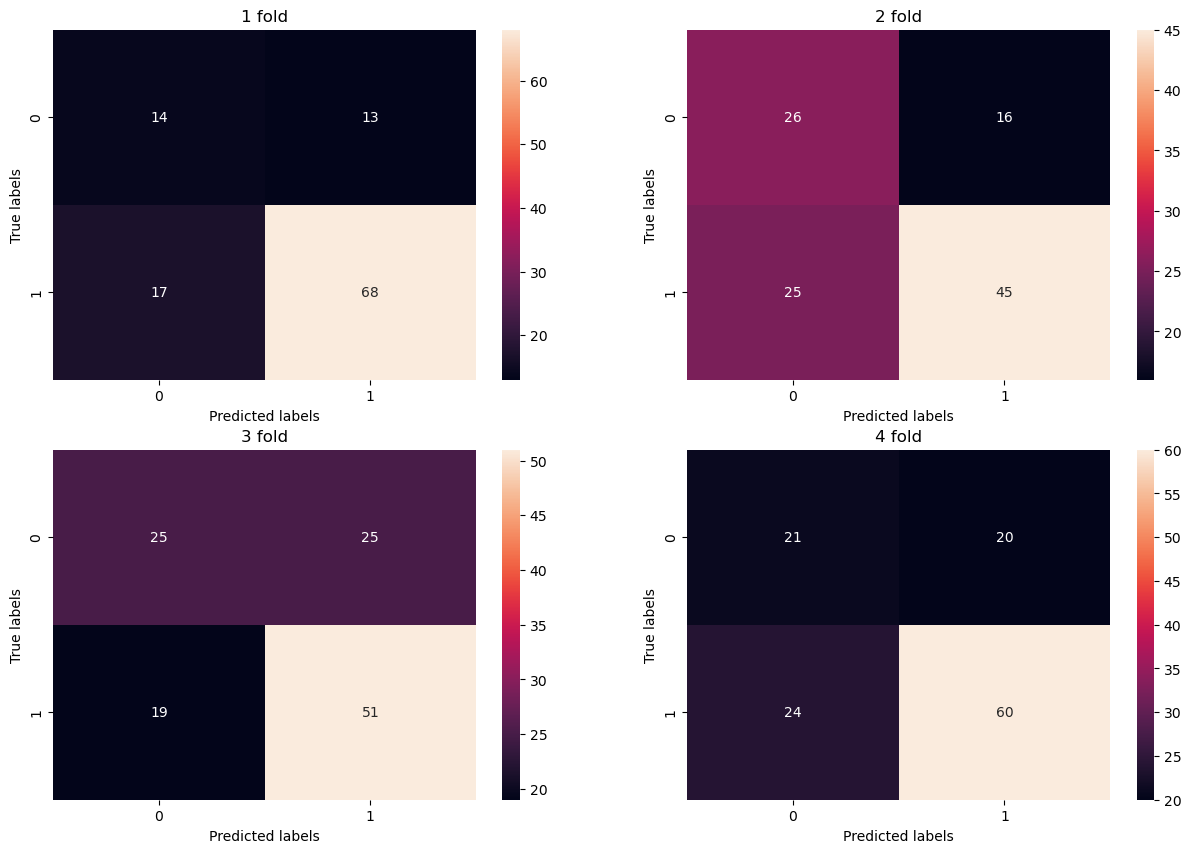

In [22]:
plot_confusion_matrix(X_train, y_train, modelling_pipeline, folds_indices=folds_indices)

<p><b><u>Note:</u> 'class_weight' didn't help. The precision value increased (because the weight value applied to the cost function for the minority class resulted in a larger error calculation, and in turn, more updates to the model coefficients), but the recall value greatly decreased.

# Gradient Boosting (LGBMClassifier) (default)

accuracy: 0.720 ± 0.040
precision: 0.750 ± 0.051
recall: 0.856 ± 0.025
f1: 0.799 ± 0.039


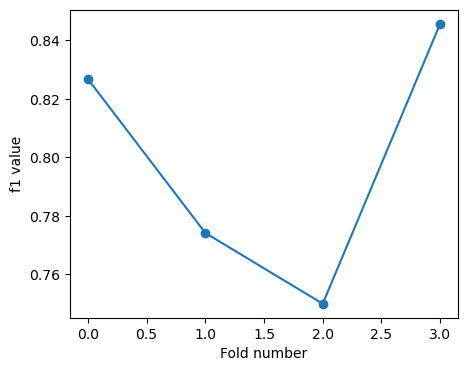

In [23]:
# cross validation

cols_to_encode = ['day']
fit_params = {'categorical_feature': [0, 1]}
base_pipelines = {}
base_pipelines['sweing'] = LGBMPipelineClf(drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'], 
                                           split_key='department', target_col='bigger_than_targeted', level='team', 
                                           cols_to_encode=cols_to_encode, fit_params=fit_params)
base_pipelines['finishing'] = LGBMPipelineClf(drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'], 
                                              split_key='department', target_col='bigger_than_targeted', level='team', 
                                              cols_to_encode=cols_to_encode, fit_params=fit_params)

modelling_pipeline_lgbm = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                               target_col='bigger_than_targeted')

scores = cross_validate(modelling_pipeline_lgbm, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

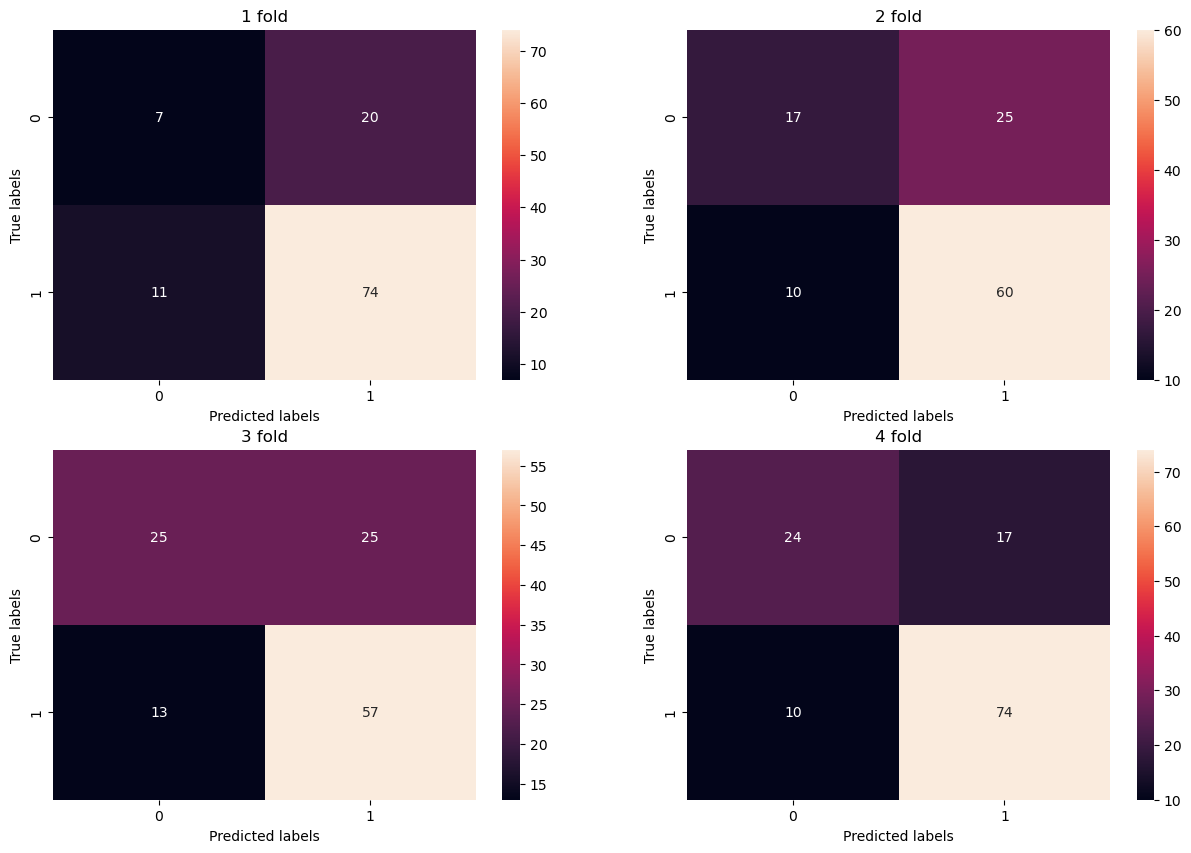

In [24]:
folds_indices = splitter(X_train)
plot_confusion_matrix(X_train, y_train, modelling_pipeline_lgbm, folds_indices=folds_indices)

accuracy: 0.768 ± 0.053
precision: 0.819 ± 0.053
recall: 0.884 ± 0.051
f1: 0.849 ± 0.043


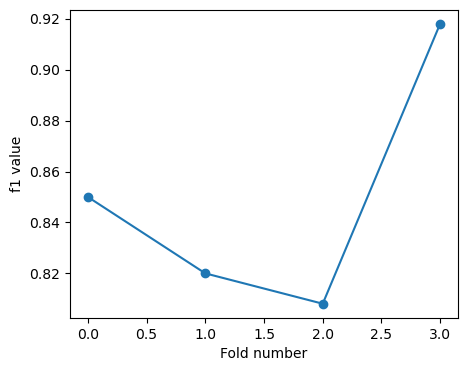

In [25]:
# sweing

X_train_sweing, y_train_sweing = X_train[X_train['department'] == 'sweing'].reset_index(drop=True), y_train.loc[X_train[X_train['department'] == 'sweing'].index].reset_index(drop=True)

scores = cross_validate(modelling_pipeline_lgbm, X_train_sweing, y_train_sweing, cv=splitter(X_train_sweing), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

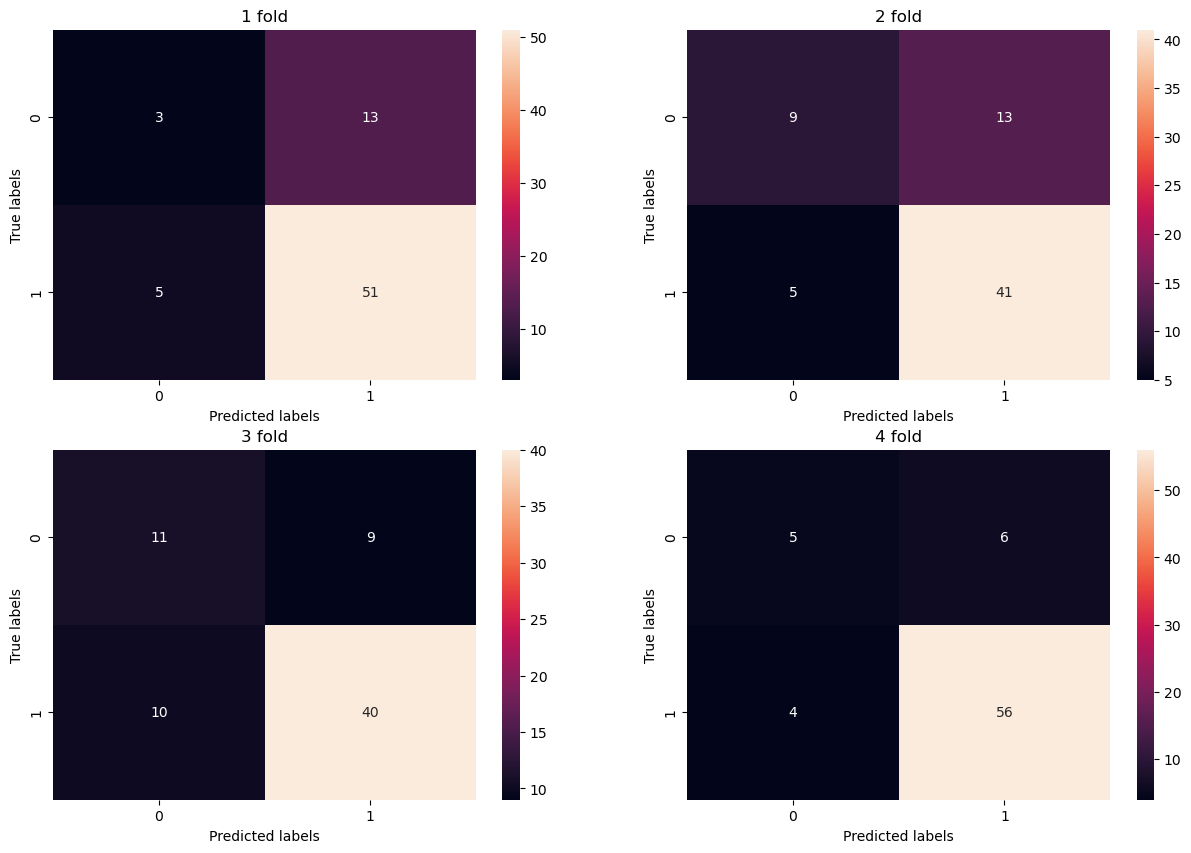

In [26]:
plot_confusion_matrix(X_train_sweing, y_train_sweing, modelling_pipeline_lgbm, folds_indices=splitter(X_train_sweing))

accuracy: 0.648 ± 0.032
precision: 0.629 ± 0.090
recall: 0.796 ± 0.036
f1: 0.698 ± 0.051


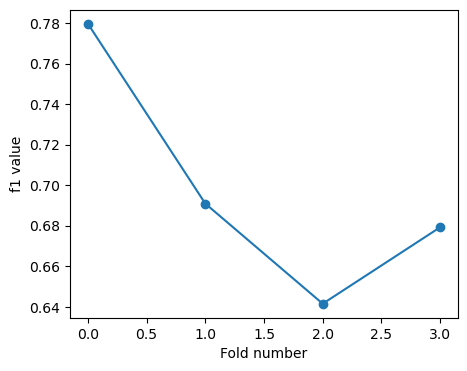

In [27]:
# finishing

X_train_finishing, y_train_finishing = X_train[X_train['department'] == 'finishing'].reset_index(drop=True), y_train.loc[X_train[X_train['department'] == 'finishing'].index].reset_index(drop=True)

scores = cross_validate(modelling_pipeline_lgbm, X_train_finishing, y_train_finishing, cv=splitter(X_train_finishing), 
                        scoring=CV_METRICS, return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

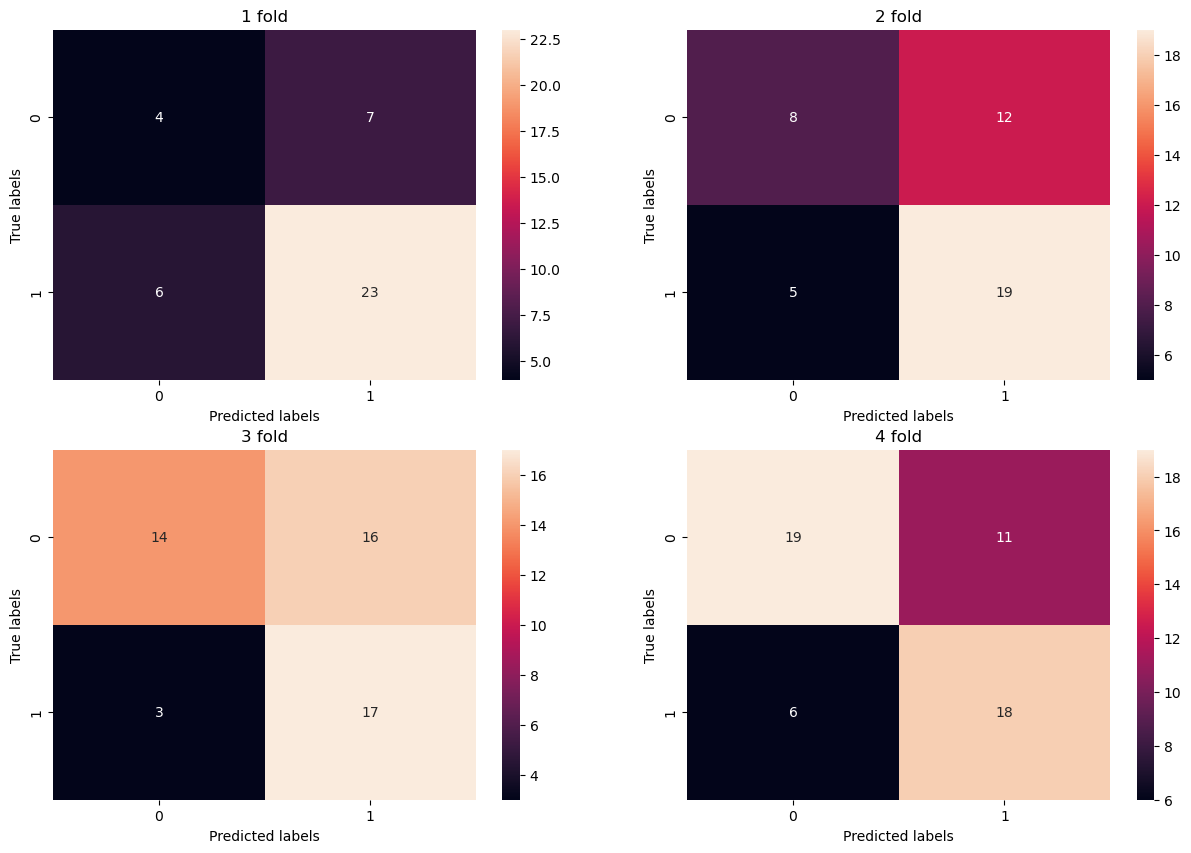

In [28]:
plot_confusion_matrix(X_train_finishing, y_train_finishing, modelling_pipeline_lgbm, folds_indices=splitter(X_train_finishing))

In [29]:
# getting X_train and y_train for the final model training

date_range_final = X_train['date'].unique()[test_size:]
X_train_final, y_train_final = X_train[X_train['date'].isin(date_range_final)], y_train.loc[X_train[X_train['date'].isin(date_range_final)].index]

accuracy: 0.705
precision: 0.9
recall: 0.706
f1: 0.791


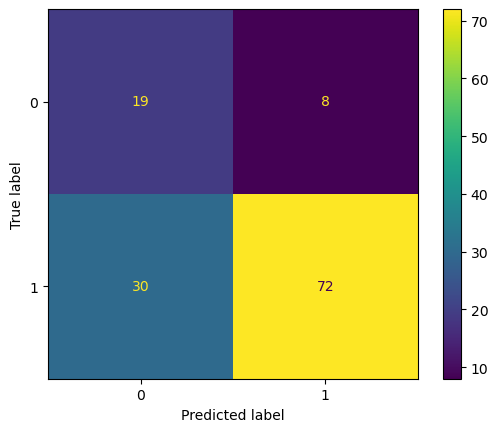

In [30]:
# fitting the final model and making predictions

modelling_pipeline_lgbm.fit(X_train_final, y_train_final)
final_preds = modelling_pipeline_lgbm.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, final_preds)

final_preds_metrics(y_test, final_preds)

In [31]:
# best gradient boosting params

drop_columns = {'sweing': ['quarter', 'idle_time', 'no_of_style_change', 'idle_men'],
                'finishing': ['quarter', 'idle_time', 'no_of_style_change', 'idle_men', 'wip', 'incentive']}

params_lgbm = {
        'n_estimators': [5, 7, 10, 15, 25, 50],
        'max_depth': [3, 4, 5, 6, 7],
        'reg_lambda': [0.001, 0.01, 0.1, 1, 5, 10, 50],
        'reg_alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50],
    }

model = LGBMClassifier()
best_boosting_params = tune_hyperparams(X=X_train, y=y_train, model=model, params=params_lgbm, inner_folds=inner_folds,
                                        fit_params={'categorical_feature': [0, 1]}, drop_columns=drop_columns)
best_boosting_params

{'finishing': {'max_depth': 3,
  'n_estimators': 50,
  'reg_alpha': 0.001,
  'reg_lambda': 0.001},
 'sweing': {'max_depth': 3,
  'n_estimators': 10,
  'reg_alpha': 0.001,
  'reg_lambda': 0.001}}

accuracy: 0.714 ± 0.069
precision: 0.735 ± 0.087
recall: 0.906 ± 0.056
f1: 0.807 ± 0.046


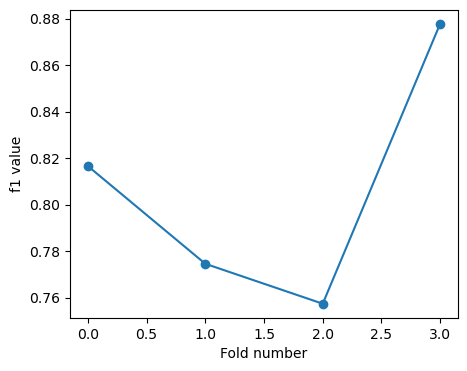

In [32]:
# cross validation

cols_to_encode = ['day']
fit_params = {'categorical_feature': [0, 1]}
base_pipelines = {}
base_pipelines['sweing'] = LGBMPipelineClf(drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'], 
                                           split_key='department', target_col='bigger_than_targeted', level='team', 
                                           cols_to_encode=cols_to_encode, params=best_boosting_params['sweing'],
                                           fit_params=fit_params)
base_pipelines['finishing'] = LGBMPipelineClf(drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'], 
                                              split_key='department', target_col='bigger_than_targeted', level='team', 
                                              cols_to_encode=cols_to_encode, params=best_boosting_params['finishing'], 
                                              fit_params=fit_params)

modelling_pipeline = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                          target_col='bigger_than_targeted')

scores = cross_validate(modelling_pipeline, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

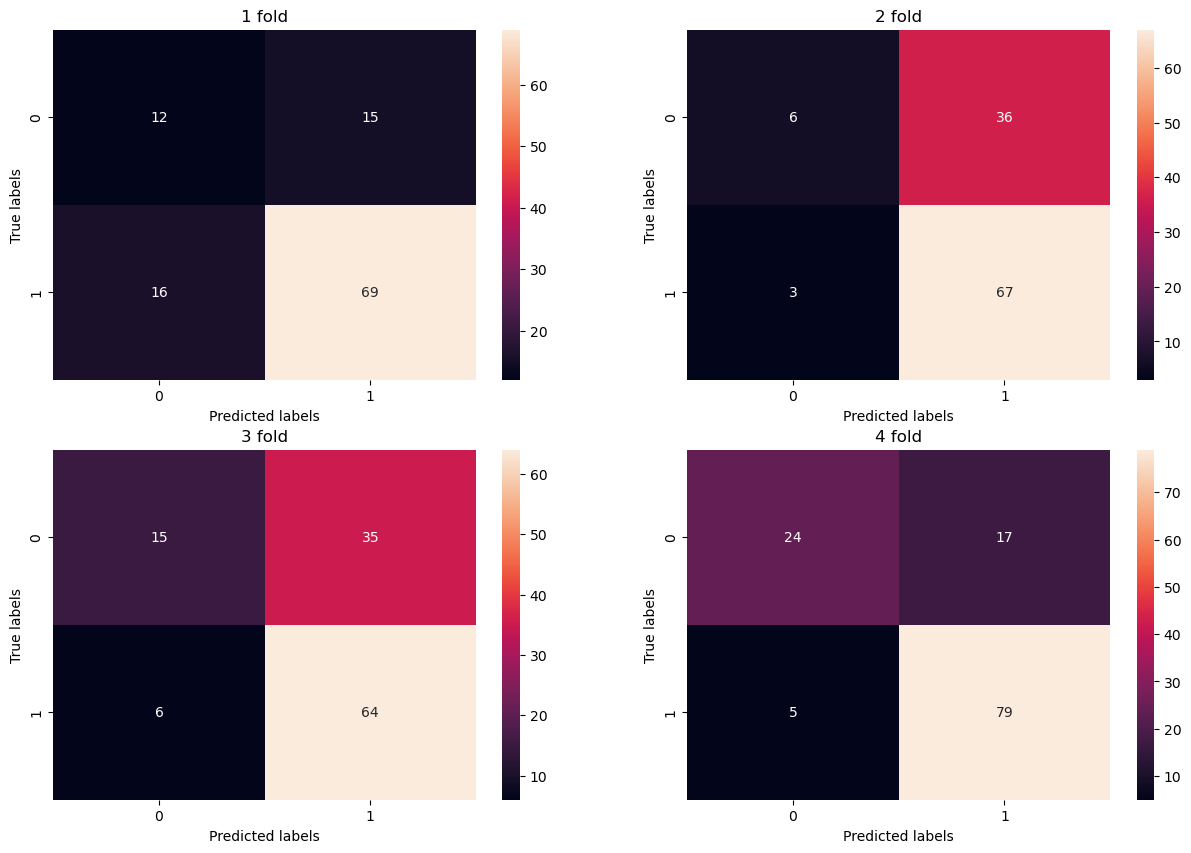

In [33]:
plot_confusion_matrix(X_train, y_train, modelling_pipeline, folds_indices=splitter(X_train))

accuracy: 0.771 ± 0.079
precision: 0.807 ± 0.085
recall: 0.927 ± 0.085
f1: 0.857 ± 0.052


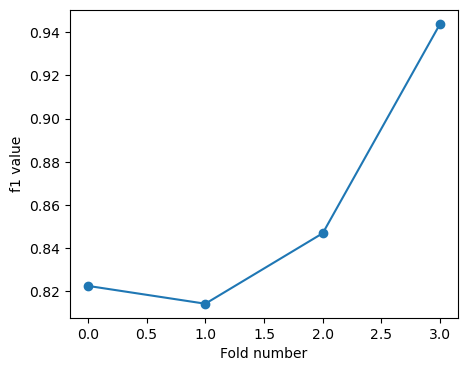

In [34]:
# sweing

X_train_sweing, y_train_sweing = X_train[X_train['department'] == 'sweing'].reset_index(drop=True), y_train.loc[X_train[X_train['department'] == 'sweing'].index].reset_index(drop=True)

scores = cross_validate(modelling_pipeline, X_train_sweing, y_train_sweing, cv=splitter(X_train_sweing), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

accuracy: 0.633 ± 0.082
precision: 0.608 ± 0.112
recall: 0.855 ± 0.015
f1: 0.705 ± 0.079


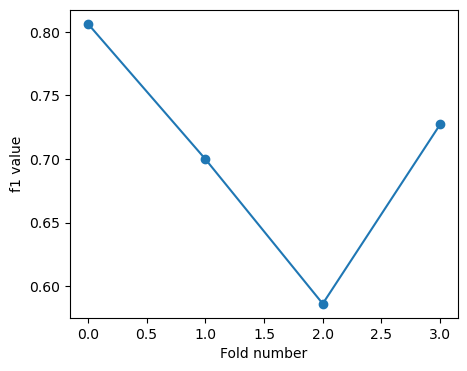

In [35]:
# finishing

X_train_finishing, y_train_finishing = X_train[X_train['department'] == 'finishing'].reset_index(drop=True), y_train.loc[X_train[X_train['department'] == 'finishing'].index].reset_index(drop=True)

scores = cross_validate(modelling_pipeline, X_train_finishing, y_train_finishing, cv=splitter(X_train_finishing), 
                        scoring=CV_METRICS, return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

accuracy: 0.752
precision: 0.907
recall: 0.765
f1: 0.83


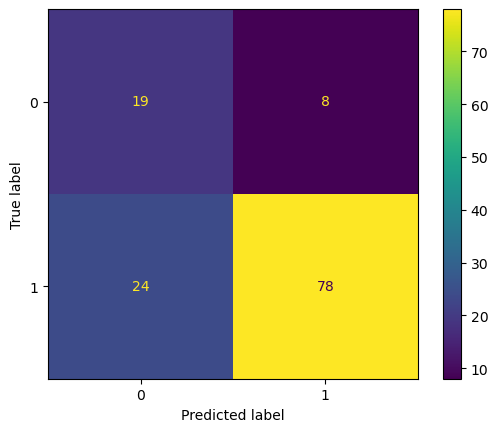

In [36]:
modelling_pipeline.fit(X_train_final, y_train_final)
final_preds = modelling_pipeline.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, final_preds)

final_preds_metrics(y_test, final_preds)

# Random Forest

accuracy: 0.739 ± 0.053
precision: 0.735 ± 0.057
recall: 0.940 ± 0.020
f1: 0.824 ± 0.043


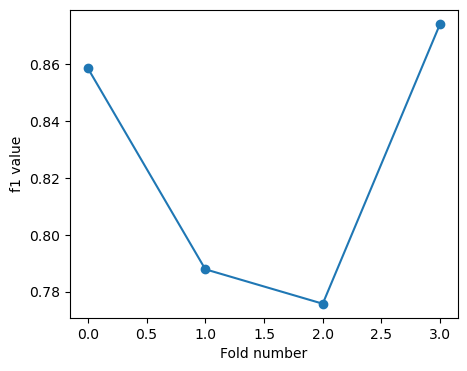

In [37]:
params_rf = {
    'boosting_type': 'rf',
    'max_depth': 4,
    'reg_lambda': 3,
    'reg_alpha': 5,
    'subsample': 0.9,
    'n_jobs': -1,
    'subsample_freq': 1,
    'min_child_samples': 6,
    'n_estimators': 12}
cols_to_encode = ['day']
fit_params = {'categorical_feature': [0, 1]}
base_pipelines_rf = {}
base_pipelines_rf['sweing'] = LGBMPipelineClf(drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'], 
                                              split_key='department', target_col='bigger_than_targeted', level='team', 
                                              cols_to_encode=cols_to_encode, params=params_rf, fit_params=fit_params)
base_pipelines_rf['finishing'] = LGBMPipelineClf(drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'], 
                                                 split_key='department', target_col='bigger_than_targeted', level='team', 
                                                 cols_to_encode=cols_to_encode, params=params_rf, fit_params=fit_params)

modelling_pipeline_rf = RecursiveTSEstimator(base_pipelines=base_pipelines_rf, split_key='department',
                                             target_col='bigger_than_targeted')

scores = cross_validate(modelling_pipeline_rf, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

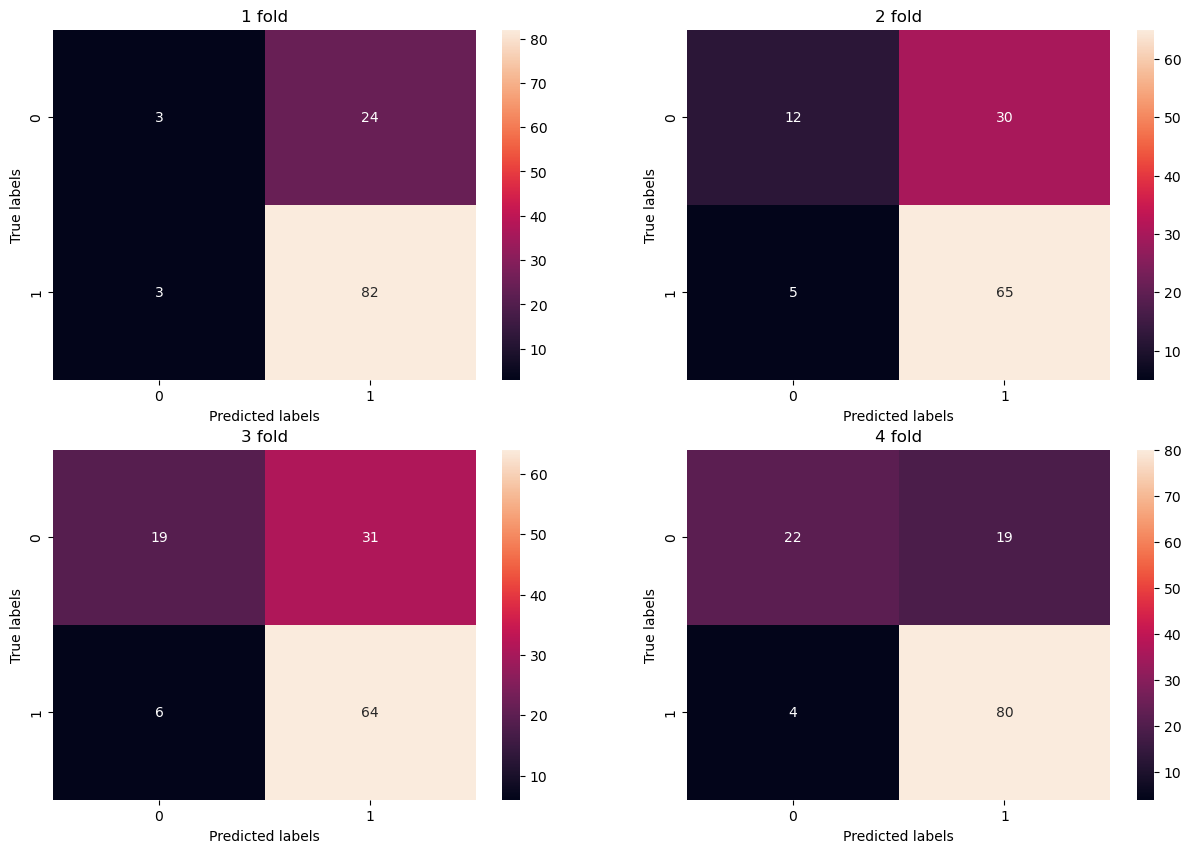

In [38]:
plot_confusion_matrix(X_train, y_train, modelling_pipeline_rf, folds_indices=splitter(X_train))

accuracy: 0.804 ± 0.059
precision: 0.828 ± 0.067
recall: 0.935 ± 0.044
f1: 0.876 ± 0.042


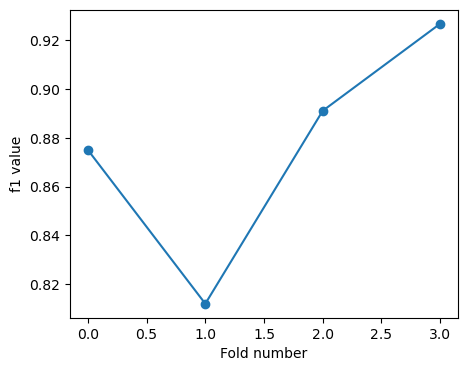

In [39]:
# sweing

X_train_sweing, y_train_sweing = X_train[X_train['department'] == 'sweing'].reset_index(drop=True), y_train.loc[X_train[X_train['department'] == 'sweing'].index].reset_index(drop=True)

scores = cross_validate(modelling_pipeline_rf, X_train_sweing, y_train_sweing, cv=splitter(X_train_sweing), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

accuracy: 0.646 ± 0.104
precision: 0.609 ± 0.119
recall: 0.951 ± 0.037
f1: 0.734 ± 0.086


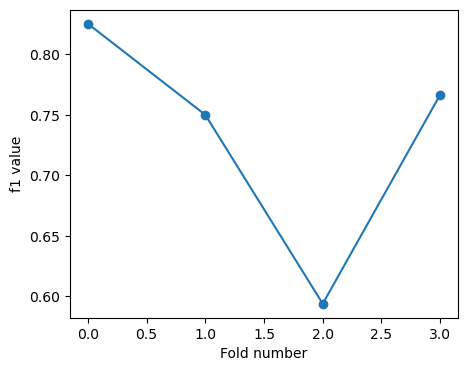

In [40]:
# finishing

X_train_finishing, y_train_finishing = X_train[X_train['department'] == 'finishing'].reset_index(drop=True), y_train.loc[X_train[X_train['department'] == 'finishing'].index].reset_index(drop=True)

scores = cross_validate(modelling_pipeline_rf, X_train_finishing, y_train_finishing, cv=splitter(X_train_finishing), 
                        scoring=CV_METRICS, return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

accuracy: 0.845
precision: 0.91
recall: 0.892
f1: 0.901


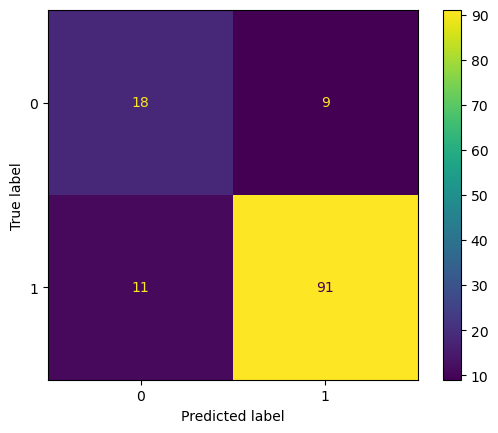

In [41]:
modelling_pipeline_rf.fit(X_train_final, y_train_final)
final_preds = modelling_pipeline_rf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, final_preds)

final_preds_metrics(y_test, final_preds)

In [42]:
params_rf = {
        'boosting_type': ['rf'],
        'max_depth': [4, 5, 6, 7],
        'reg_lambda': [0.001, 0.01, 0.1, 1, 5, 10, 50],
        'reg_alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50],
        'subsample': [0.9, 0.95, 0.98],
        'n_jobs': [-1],
        'subsample_freq': [1],
        'n_estimators': [7, 10, 12, 15, 20, 25]}

model = LGBMClassifier()
best_rf_hyperparams = tune_hyperparams(X=X_train, y=y_train, model=model, params=params_rf, inner_folds=inner_folds,
                                       fit_params={'categorical_feature': [0, 1]}, drop_columns=drop_columns)
best_rf_hyperparams

{'finishing': {'boosting_type': 'rf',
  'max_depth': 4,
  'n_estimators': 7,
  'n_jobs': -1,
  'reg_alpha': 0.001,
  'reg_lambda': 0.001,
  'subsample': 0.9,
  'subsample_freq': 1},
 'sweing': {'boosting_type': 'rf',
  'max_depth': 4,
  'n_estimators': 7,
  'n_jobs': -1,
  'reg_alpha': 0.001,
  'reg_lambda': 5,
  'subsample': 0.9,
  'subsample_freq': 1}}

accuracy: 0.725 ± 0.062
precision: 0.749 ± 0.071
recall: 0.880 ± 0.043
f1: 0.807 ± 0.050


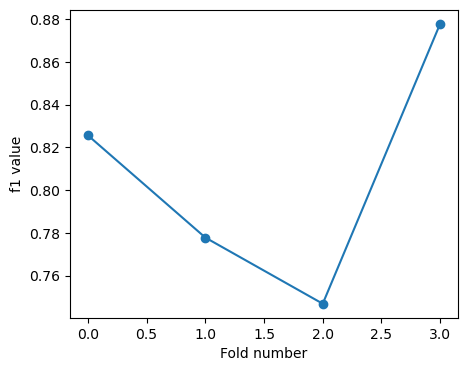

In [43]:
cols_to_encode = ['day']
fit_params = {'categorical_feature': [0, 1]}
base_pipelines_rf = {}
base_pipelines_rf['sweing'] = LGBMPipelineClf(drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'], 
                                              split_key='department', target_col='bigger_than_targeted', level='team', 
                                              cols_to_encode=cols_to_encode, params=best_rf_hyperparams['sweing'], 
                                              fit_params=fit_params)
base_pipelines_rf['finishing'] = LGBMPipelineClf(drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'], 
                                                 split_key='department', target_col='bigger_than_targeted', level='team', 
                                                 cols_to_encode=cols_to_encode, params=best_rf_hyperparams['finishing'], 
                                                 fit_params=fit_params)

modelling_pipeline_rf = RecursiveTSEstimator(base_pipelines=base_pipelines_rf, split_key='department',
                                             target_col='bigger_than_targeted')

scores = cross_validate(modelling_pipeline_rf, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

accuracy: 0.800 ± 0.075
precision: 0.855 ± 0.065
recall: 0.881 ± 0.053
f1: 0.867 ± 0.053


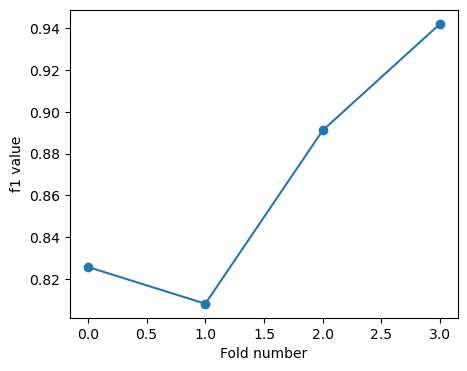

In [44]:
# sweing

X_train_sweing, y_train_sweing = X_train[X_train['department'] == 'sweing'].reset_index(drop=True), y_train.loc[X_train[X_train['department'] == 'sweing'].index].reset_index(drop=True)

scores = cross_validate(modelling_pipeline_rf, X_train_sweing, y_train_sweing, cv=splitter(X_train_sweing), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

accuracy: 0.620 ± 0.124
precision: 0.590 ± 0.139
recall: 0.868 ± 0.099
f1: 0.698 ± 0.125


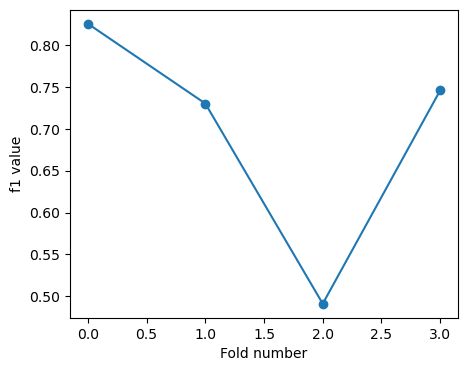

In [45]:
# finishing

X_train_finishing, y_train_finishing = X_train[X_train['department'] == 'finishing'].reset_index(drop=True), y_train.loc[X_train[X_train['department'] == 'finishing'].index].reset_index(drop=True)

scores = cross_validate(modelling_pipeline_rf, X_train_finishing, y_train_finishing, cv=splitter(X_train_finishing), 
                        scoring=CV_METRICS, return_estimator=True, error_score='raise', n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['f1'])

accuracy: 0.736
precision: 0.925
recall: 0.725
f1: 0.813


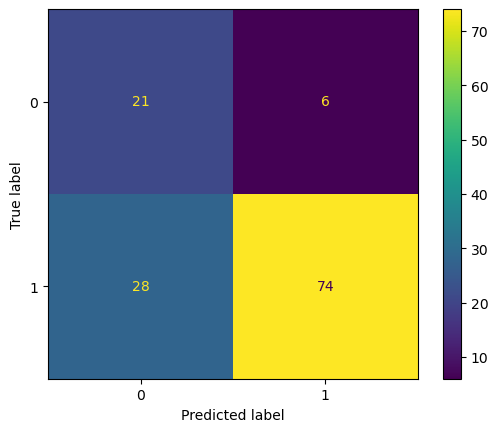

In [46]:
modelling_pipeline_rf.fit(X_train_final, y_train_final)
final_preds = modelling_pipeline_rf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, final_preds)

final_preds_metrics(y_test, final_preds)

# Compare models

In [47]:
# Logistic Regression
base_pipelines_logreg = {}
base_pipelines_logreg['sweing'] = LogRegPipeline(cols_to_scale=['smv', 'wip', 'incentive', 'no_of_workers', 'over_time'],
                                                 cols_to_encode=['day', 'team'], predict_proba=True,
                                                 drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'], split_key='department', 
                                                 target_col='bigger_than_targeted', level='team')
base_pipelines_logreg['finishing'] = LogRegPipeline(cols_to_scale=['smv', 'no_of_workers', 'over_time'],
                                                    cols_to_encode=['day', 'team'], predict_proba=True,
                                                    drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'], 
                                                    split_key='department', target_col='bigger_than_targeted', level='team')

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines_logreg, split_key='department',
                                                 target_col='bigger_than_targeted', predict_proba=True)
modelling_pipeline_logreg.fit(X_train_final, y_train_final)

# Gradient Boosting
cols_to_encode = ['day']
base_pipelines_lgbm = {}
base_pipelines_lgbm['sweing'] = LGBMPipelineClf(drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'], 
                                                split_key='department', target_col='bigger_than_targeted', level='team',
                                                cols_to_encode=cols_to_encode, predict_proba=True, fit_params=fit_params,
                                                params=best_boosting_params['sweing'])
base_pipelines_lgbm['finishing'] = LGBMPipelineClf(drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'], 
                                                   split_key='department', target_col='bigger_than_targeted', level='team', 
                                                   cols_to_encode=cols_to_encode, predict_proba=True, fit_params=fit_params,
                                                   params=best_boosting_params['finishing'])

modelling_pipeline_lgbm = RecursiveTSEstimator(base_pipelines=base_pipelines_lgbm, split_key='department',
                                               target_col='bigger_than_targeted', predict_proba=True)
modelling_pipeline_lgbm.fit(X_train_final, y_train_final)

# Random Forest
base_pipelines_rf = {}
base_pipelines_rf['sweing'] = LGBMPipelineClf(drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'], 
                                              split_key='department', target_col='bigger_than_targeted', level='team', 
                                              cols_to_encode=cols_to_encode, params=best_rf_hyperparams['sweing'], 
                                              fit_params=fit_params, predict_proba=True)
base_pipelines_rf['finishing'] = LGBMPipelineClf(drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'], 
                                                 split_key='department', target_col='bigger_than_targeted', level='team', 
                                                 cols_to_encode=cols_to_encode, params=best_rf_hyperparams['finishing'], 
                                                 fit_params=fit_params, predict_proba=True)

modelling_pipeline_rf = RecursiveTSEstimator(base_pipelines=base_pipelines_rf, split_key='department', predict_proba=True,
                                             target_col='bigger_than_targeted').fit(X_train_final, y_train_final)

In [48]:
models = {'LogReg': modelling_pipeline_logreg, 'Gradient Boosting': modelling_pipeline_lgbm, 'Random Forest': modelling_pipeline_rf}

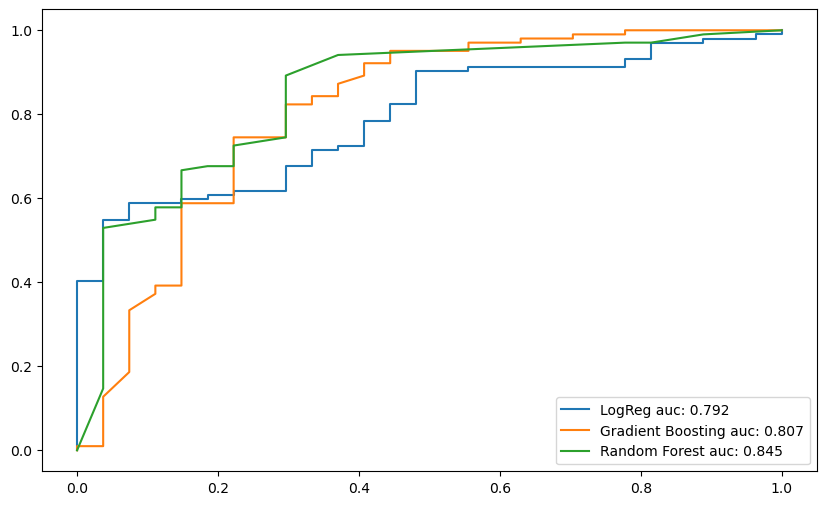

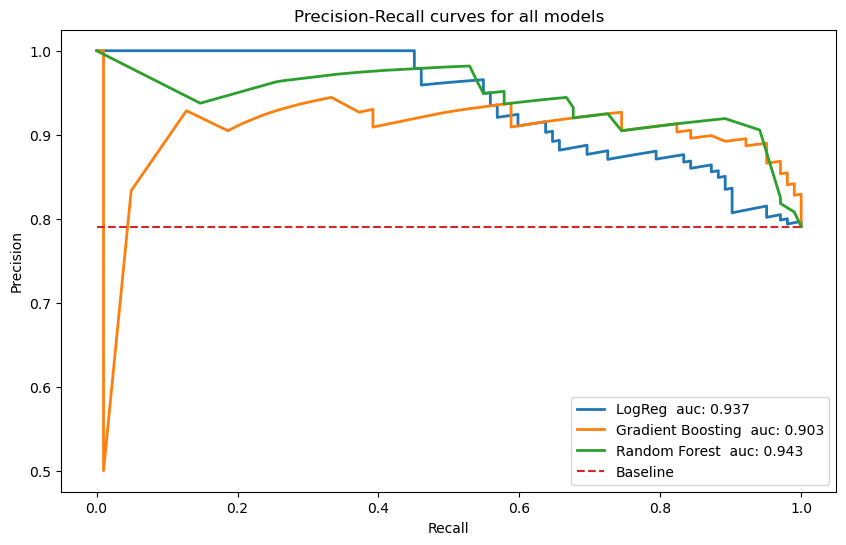

In [49]:
plot_roc_auc(models, X_test, y_test)
plot_precision_recall_auc(models, X_test, y_test)

In [50]:
# Logistic Regression
base_pipelines_logreg = {}
base_pipelines_logreg['sweing'] = LogRegPipeline(cols_to_scale=['smv', 'wip', 'incentive', 'no_of_workers', 'over_time'],
                                                 cols_to_encode=['day', 'team'], predict_proba=False,
                                                 drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'], split_key='department', 
                                                 target_col='bigger_than_targeted', level='team')
base_pipelines_logreg['finishing'] = LogRegPipeline(cols_to_scale=['smv', 'no_of_workers', 'over_time'],
                                                    cols_to_encode=['day', 'team'], predict_proba=False,
                                                    drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'], 
                                                    split_key='department', target_col='bigger_than_targeted', level='team')

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines_logreg, split_key='department',
                                                 target_col='bigger_than_targeted', predict_proba=False)
modelling_pipeline_logreg.fit(X_train_final, y_train_final)

# Gradient Boosting
cols_to_encode = ['day']
base_pipelines_lgbm = {}
base_pipelines_lgbm['sweing'] = LGBMPipelineClf(drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'], 
                                                split_key='department', target_col='bigger_than_targeted', level='team',
                                                cols_to_encode=cols_to_encode, predict_proba=False, fit_params=fit_params,
                                                params=best_boosting_params['sweing'])
base_pipelines_lgbm['finishing'] = LGBMPipelineClf(drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'], 
                                                   split_key='department', target_col='bigger_than_targeted', level='team', 
                                                   cols_to_encode=cols_to_encode, predict_proba=False, fit_params=fit_params,
                                                   params=best_boosting_params['finishing'])

modelling_pipeline_lgbm = RecursiveTSEstimator(base_pipelines=base_pipelines_lgbm, split_key='department',
                                               target_col='bigger_than_targeted', predict_proba=False)
modelling_pipeline_lgbm.fit(X_train_final, y_train_final)

# Random Forest
base_pipelines_rf = {}
base_pipelines_rf['sweing'] = LGBMPipelineClf(drop_columns=['quarter', 'idle_time', 'no_of_style_change', 'idle_men'], 
                                              split_key='department', target_col='bigger_than_targeted', level='team', 
                                              cols_to_encode=cols_to_encode, params=best_rf_hyperparams['sweing'], 
                                              fit_params=fit_params, predict_proba=False)
base_pipelines_rf['finishing'] = LGBMPipelineClf(drop_columns=['quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive'], 
                                                 split_key='department', target_col='bigger_than_targeted', level='team', 
                                                 cols_to_encode=cols_to_encode, params=best_rf_hyperparams['finishing'], 
                                                 fit_params=fit_params, predict_proba=False)

modelling_pipeline_rf = RecursiveTSEstimator(base_pipelines=base_pipelines_rf, split_key='department', predict_proba=False,
                                             target_col='bigger_than_targeted').fit(X_train_final, y_train_final)

In [51]:
models = {'LogReg': modelling_pipeline_logreg, 'Gradient Boosting': modelling_pipeline_lgbm, 'Random Forest': modelling_pipeline_rf}

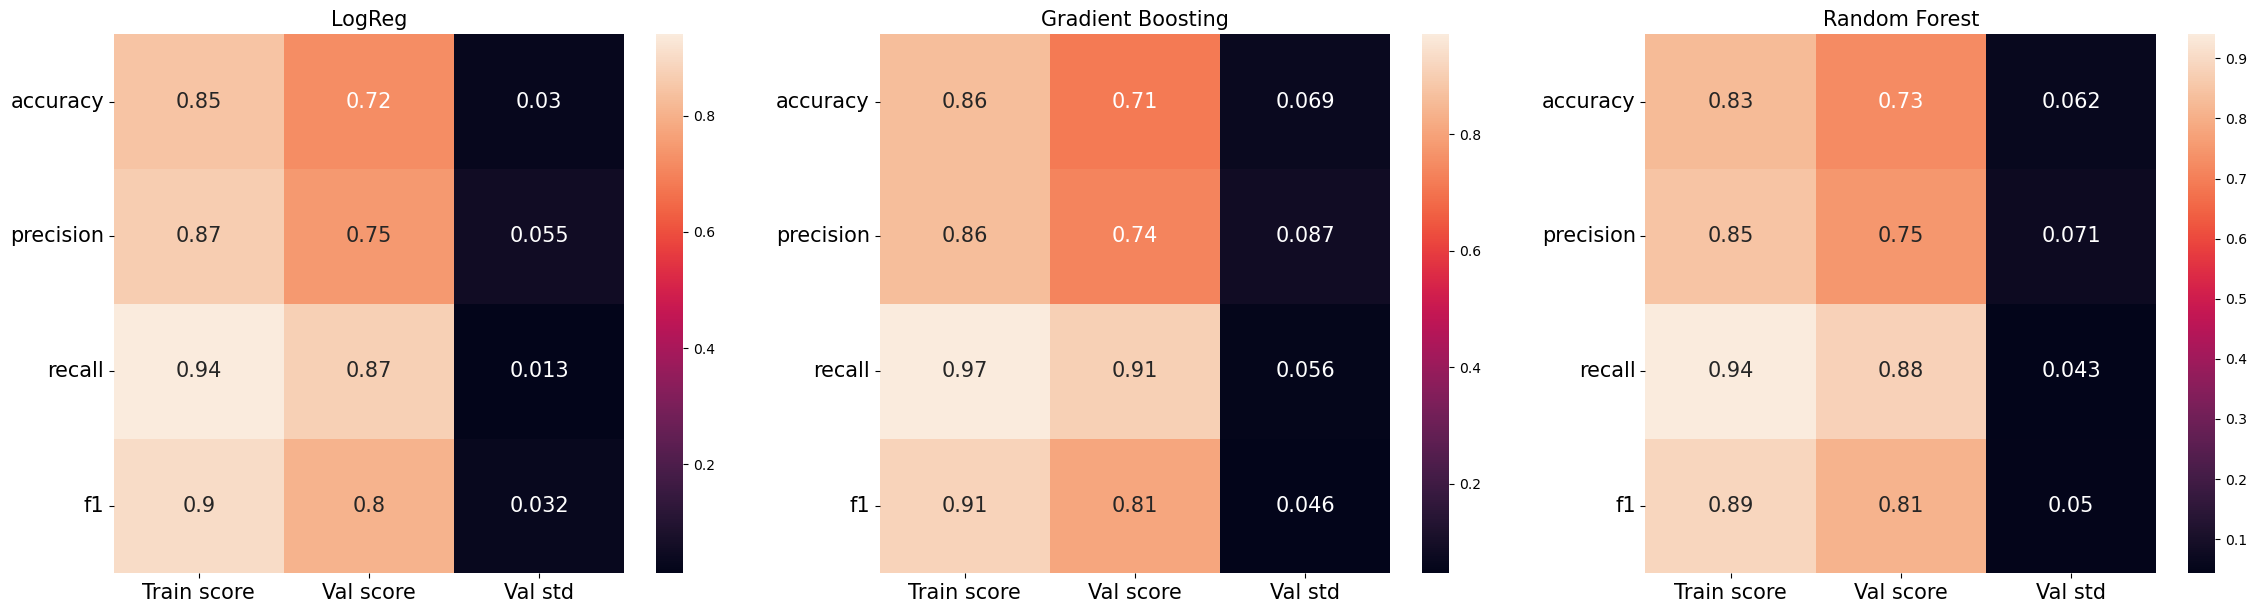

In [52]:
### cross-validation comparison

cv_scores = {}
plt.figure(figsize=(28, 7))
for i, m in enumerate(models.keys()):
    plt.subplot(1, 3, i + 1)
    scores = cross_validate(models[m], X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                            return_estimator=True, error_score='raise', return_train_score=True, n_jobs=-1)
    cv_scores[model] = format_cv_test_scores(scores, save_scores=True, print_scores=False, save_train_scores=True)
    metric_values = {}
    for metric_name in cv_scores[model][0].keys():
        metric_values[metric_name] = [cv_scores[model][0][metric_name], cv_scores[model][1][metric_name], cv_scores[model][2][metric_name]]
    sns.heatmap(data=pd.DataFrame(data=metric_values, index=['Train score', 'Val score', 'Val std']).T, annot=True, annot_kws={'fontsize': 15})
    plt.yticks(fontsize=15, rotation=0)
    plt.xticks(fontsize=15)
    plt.title(m, fontsize=15)

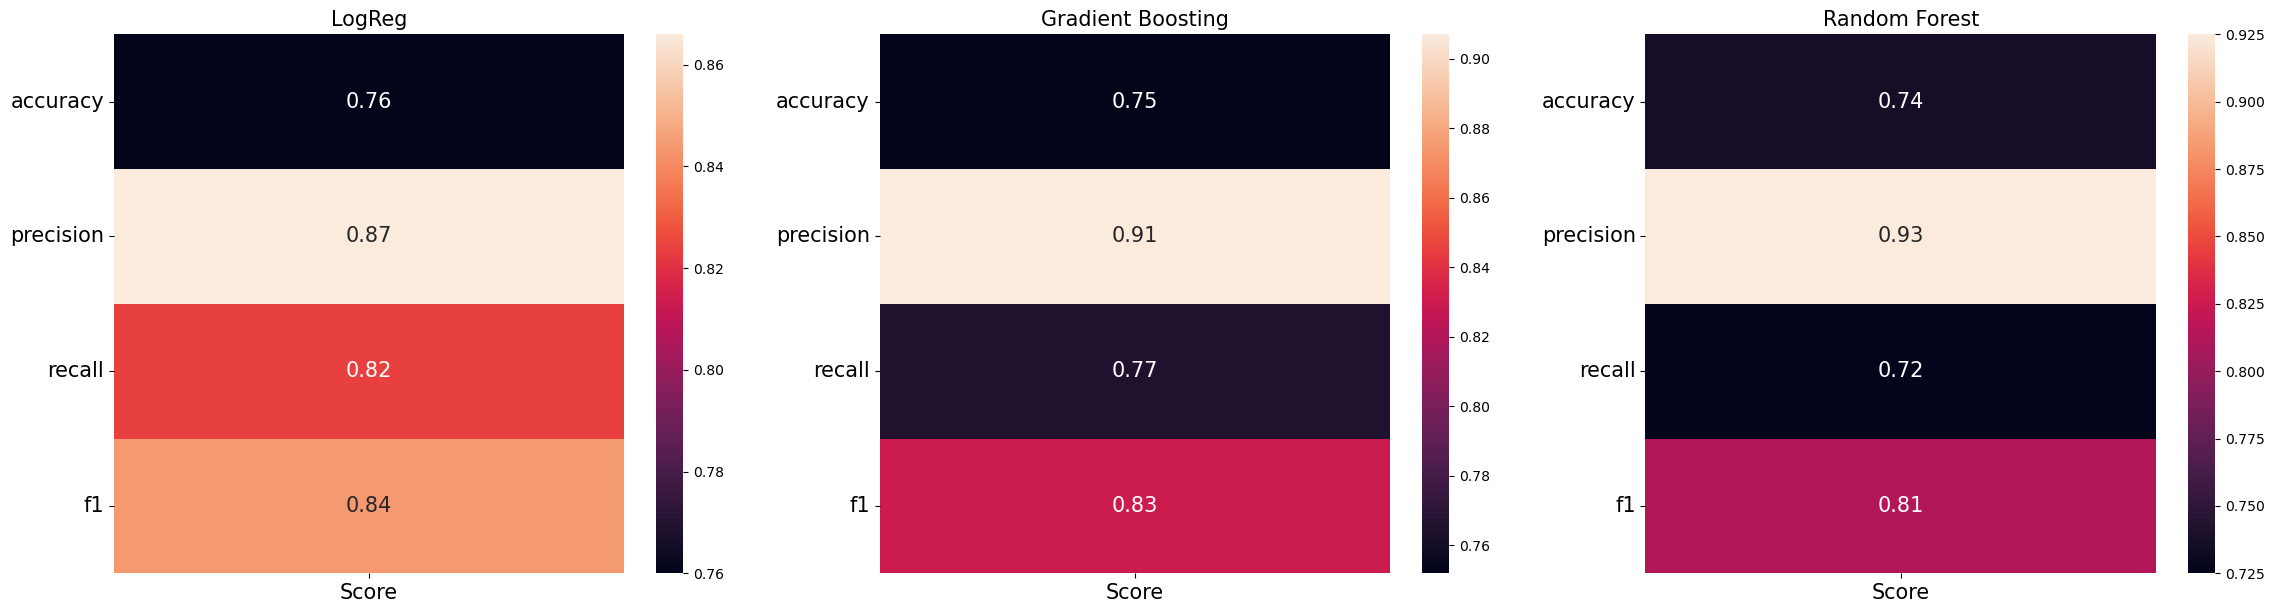

In [53]:
### test set comparison

final_scores = {}
plt.figure(figsize=(28, 7))
for i, m in enumerate(models.keys()):
    plt.subplot(1, 3, i + 1)
    models[m].fit(X_train_final, y_train_final)
    final_scores[m] = final_preds_metrics(y_test, models[m].predict(X_test), save_scores=True, print_scores=False)
    if i == 2:
        sns.heatmap(data=pd.DataFrame(data=final_scores[m], index=['Score']).T, annot=True, annot_kws={'fontsize': 15})
    else:
        sns.heatmap(data=pd.DataFrame(data=final_scores[m], index=['Score']).T, annot=True, annot_kws={'fontsize': 15})
    plt.yticks(fontsize=15, rotation=0)
    plt.xticks(fontsize=15)
    plt.title(m, fontsize=15)